<a href="https://colab.research.google.com/github/japeshmethuku17/food-101_4class/blob/master/food_101_4class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # **Computer Vision and Deep Learning**


# **Finetuning the RESNET50 model to classify the images from food101_4class dataset**

# **Importing all the necessary libraries**

In [2]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras import utils
from tensorflow.keras import datasets, layers, models, callbacks
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD, Adam, Adagrad, Adadelta, RMSprop
from tensorflow.python.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow.keras.layers import Input, Add, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import model_from_json
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import pydot
from matplotlib.pyplot import imshow
import scipy.misc
import os 
import glob
import gc
import numpy as np
import pandas as pd
import cv2
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import os
import zipfile
from google.colab import drive
import seaborn as sns
from time import time
print("tensorflow version:",tf.__version__)

tensorflow version: 2.2.0


# **Mount Google Drive to load the data**

In [3]:
drive.mount('/content/drive/', force_remount=True)

zip_ref = zipfile.ZipFile("/content/drive/My Drive/food101_4class.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


Specifying the directories

In [0]:
training_dir = '/tmp/train/'
testing_dir = '/tmp/test/'
validation_dir = '/tmp/validation/'

# **Exploratory Data Analysis**

### **Comparing the images in Training and Validation sets**

In [6]:
from PIL import Image
count1=0
CATEGORIES = ['chicken_curry', 'hamburger', 'omelette', 'waffles']
from tqdm import tqdm
for category in CATEGORIES:
      path1 = os.path.join(training_dir, category)
      path2 = os.path.join(validation_dir, category)
      class_num = CATEGORIES.index(category)
      for img in tqdm(os.listdir(path2)):
        img1 = cv2.imread(os.path.join(path1, img), cv2.IMREAD_UNCHANGED)
        img2 = cv2.imread(os.path.join(path2, img), cv2.IMREAD_UNCHANGED)
        im1 = Image.open(os.path.join(path1, img))
        im2 = Image.open(os.path.join(path2, img))
        if im1 == im2:
          count1+=1
print()
print(count1,"matches found!")

100%|██████████| 530/530 [00:07<00:00, 72.11it/s]


2217 matches found!


All images in the validation set are found in the training set.

### **Comparing the images in Training and Testing sets**

In [7]:
from PIL import Image
count1=0
CATEGORIES = ['chicken_curry', 'hamburger', 'omelette', 'waffles']
from tqdm import tqdm
for category in CATEGORIES:
      path1 = os.path.join(training_dir, category)
      path2 = os.path.join(testing_dir, category)
      class_num = CATEGORIES.index(category)
      for img in tqdm(os.listdir(path2)):
        img1 = cv2.imread(os.path.join(path1, img), cv2.IMREAD_UNCHANGED)
        img2 = cv2.imread(os.path.join(path2, img), cv2.IMREAD_UNCHANGED)
        im1 = Image.open(os.path.join(path1, img))
        im2 = Image.open(os.path.join(path2, img))
        if im1 == im2:
          count1+=1
print()
print(count1,"matches found!")

100%|██████████| 524/524 [00:08<00:00, 62.53it/s]


2128 matches found!


All images in the testing set are found in the training set.

**Checking the availability of GPU for computing**

In [8]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# **Using ImageDataGenerator to feed the data into the network**

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)
train_data = train_datagen.flow_from_directory('/tmp/train/', class_mode='categorical', target_size=(224,224), batch_size=32)
test_data = test_datagen.flow_from_directory('/tmp/test/', class_mode='categorical', target_size=(224,224), batch_size=32,shuffle=False)
valid_data = valid_datagen.flow_from_directory('/tmp/validation/', class_mode='categorical', target_size=(224,224), batch_size=32,shuffle=False)

Found 4000 images belonging to 4 classes.
Found 2128 images belonging to 4 classes.
Found 2217 images belonging to 4 classes.


# **Loading the pre-trained ResNet50 model**

Specifying the weights and input_shape. The "include_top = False" indicates that the pre-trained model is used on another classification challenge instead of ImageNet. In this case, we want to classify images of four different categories.

In [10]:
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

94773248/94765736 [==============================] - 1s 0us/step


Displaying the pre-trained ResNet50 model's architecture

In [11]:
resnet_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

# **Adding Fully Connected Layer on the top of pre-trained ResNet50 base layer**

In [12]:
model = models.Sequential()
model.add(resnet_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2048, activation='relu'))
model.add(layers.Dense(4, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dropout (Dropout)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 2048)              205522944 
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 8196      
Total params: 229,118,852
Trainable params: 229,065,732
Non-trainable params: 53,120
_________________________________________________________________


# **Freezing the pre-trained ResNet50 base**

In [0]:
for layer in resnet_base.layers[:]:
  layer.trainable = False

Display the architecture of the full CNN model

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dropout (Dropout)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 2048)              205522944 
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 8196      
Total params: 229,118,852
Trainable params: 205,531,140
Non-trainable params: 23,587,712
_________________________________________________________________


Specifying the learning rate

In [0]:
learning_rate = 1e-4

Compile the CNN model

In [0]:
model.compile(optimizer=optimizers.RMSprop(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
training_dir = '/tmp/train/'
testing_dir = '/tmp/test/'
validation_dir = '/tmp/validation/'

Specifying the callbacks

In [0]:
callbacks_list = [callbacks.ModelCheckpoint(
        filepath = 'resnet-finetune-model.h5',
        monitor = 'val_loss',
        save_best_only = True),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=5,
            mode='min',
            min_lr=1e-8),
        callbacks.CSVLogger(
            filename='resnet-finetune-model.csv',
            separator = ',',
            append = False)]

# **Training the fully connected layer only (ResNet50 base is frozen)**

In [19]:
batch_size = 32
history = model.fit(train_data,
                             steps_per_epoch=4000//batch_size,
                             epochs=5,
                             validation_data=valid_data,
                             validation_steps=2217//batch_size,
                             callbacks=callbacks_list)

Epoch 1/5
125/125 [==============================] - 45s 364ms/step - loss: 3.3539 - accuracy: 0.3030 - val_loss: 2.1746 - val_accuracy: 0.2794 - lr: 1.0000e-04
Epoch 2/5
125/125 [==============================] - 34s 273ms/step - loss: 1.9500 - accuracy: 0.3288 - val_loss: 2.6390 - val_accuracy: 0.3383 - lr: 1.0000e-04
Epoch 3/5
125/125 [==============================] - 50s 397ms/step - loss: 1.7920 - accuracy: 0.3495 - val_loss: 1.7001 - val_accuracy: 0.3736 - lr: 1.0000e-04
Epoch 4/5
125/125 [==============================] - 47s 379ms/step - loss: 1.6570 - accuracy: 0.3587 - val_loss: 1.4746 - val_accuracy: 0.4393 - lr: 1.0000e-04
Epoch 5/5
125/125 [==============================] - 34s 269ms/step - loss: 1.5839 - accuracy: 0.3672 - val_loss: 2.1099 - val_accuracy: 0.3741 - lr: 1.0000e-04


# **Unfreezing the ResNet5c block**

In [20]:
#resnet_base.trainable = True
for layer in resnet_base.layers[:165]:
  layer.trainable = False
for layer in resnet_base.layers[165:]:
  layer.trainable = True

for i, layer in enumerate(resnet_base.layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

# **Compile the final CNN model with fully connected layer and the ResNet50 base after unfreezing the ResNet5c block**

In [21]:
model.compile(optimizer=optimizers.RMSprop(lr=learning_rate),
              loss='categorical_crossentropy',
             metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dropout (Dropout)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 2048)              205522944 
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 8196      
Total params: 229,118,852
Trainable params: 209,996,804
Non-trainable params: 19,122,048
_________________________________________________________________


# **Fit the CNN model**

In [22]:
print('Fit the model...')
t0 = time() #timing counter starts
print('The model has started learning...')
nepochs=50
batch_size=32
history=model.fit(train_data, #Learning process starts
                  steps_per_epoch=4000//batch_size,
                  epochs=nepochs,
                  validation_data=valid_data,
                  validation_steps=2217//batch_size,
                  callbacks=callbacks_list)
print('Fit model took', int(time() - t0),'s') #time is calculated with the help of counter

Fit the model...
The model has started learning...
Epoch 1/50
125/125 [==============================] - 53s 426ms/step - loss: 1.7878 - accuracy: 0.3740 - val_loss: 1.3114 - val_accuracy: 0.3338 - lr: 1.0000e-04
Epoch 2/50
125/125 [==============================] - 48s 383ms/step - loss: 1.3467 - accuracy: 0.4022 - val_loss: 1.3056 - val_accuracy: 0.3967 - lr: 1.0000e-04
Epoch 3/50
125/125 [==============================] - 34s 272ms/step - loss: 1.2706 - accuracy: 0.4417 - val_loss: 1.3742 - val_accuracy: 0.3678 - lr: 1.0000e-04
Epoch 4/50
125/125 [==============================] - 51s 410ms/step - loss: 1.2287 - accuracy: 0.4647 - val_loss: 1.1487 - val_accuracy: 0.4991 - lr: 1.0000e-04
Epoch 5/50
125/125 [==============================] - 34s 274ms/step - loss: 1.1700 - accuracy: 0.4848 - val_loss: 1.1816 - val_accuracy: 0.5068 - lr: 1.0000e-04
Epoch 6/50
125/125 [==============================] - 35s 278ms/step - loss: 1.1002 - accuracy: 0.5192 - val_loss: 1.2020 - val_accuracy: 0

# **Plot the learning curves for Accuracy and Loss**

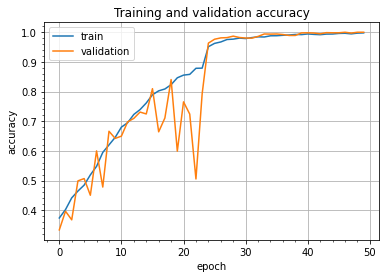

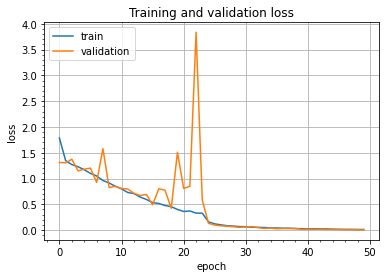

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.minorticks_on()
plt.grid(True)
plt.legend(['train', 'validation'], loc='upper left')
# save image to disk
plt.savefig('RESNET Final Model Accuracy', dpi=250)
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.minorticks_on()
plt.grid(True)
plt.legend(['train', 'validation'], loc='upper left')
# save image to disk
plt.savefig('RESNET Final Model Loss', dpi=250)
plt.show()

# **Evaluate the model**

In [24]:
validation_datagen = ImageDataGenerator(rescale = 1./255)
evaluate_datagen = validation_datagen.flow_from_directory(validation_dir, class_mode='categorical', target_size=(224,224), batch_size=1,shuffle=False)

Found 2217 images belonging to 4 classes.


In [25]:
print('Validate the model')
final_result = model.evaluate(
    evaluate_datagen,
    steps = 2217)

Validate the model
2217/2217 [==============================] - 33s 15ms/step - loss: 0.0037 - accuracy: 1.0000


In [26]:
t0 = time()
evaluate_datagen.reset()
val_predict = model.predict(
    evaluate_datagen,
    steps = 2217,
    verbose = 1)
print('Time taken to evaluate the model:',int(time()-t0),'seconds')

2217/2217 [==============================] - 31s 14ms/step
Time taken to evaluate the model: 32 seconds


# **Produce a classification report for Validation set**

In [27]:
validation_samples = val_predict.shape[0]
print('Number of data points in validation set:',validation_samples)

Number of data points in validation set: 2217


In [0]:
val_predicted_classes = np.argmax(val_predict, axis = 1)
val_true_classes = evaluate_datagen.classes
val_class_labels = list(evaluate_datagen.class_indices.keys())

Performance metrics for Validation set

In [29]:
validation_report = metrics.classification_report(val_true_classes, val_predicted_classes, target_names=val_class_labels)
print('The validation report is as follows:')
print(validation_report)

The validation report is as follows:
               precision    recall  f1-score   support

chicken_curry       1.00      1.00      1.00       569
    hamburger       1.00      1.00      1.00       541
     omelette       1.00      1.00      1.00       577
      waffles       1.00      1.00      1.00       530

     accuracy                           1.00      2217
    macro avg       1.00      1.00      1.00      2217
 weighted avg       1.00      1.00      1.00      2217



Confusion matrix with the numbers of true and predicted labels for each class in Validation set

In [30]:
val_conf_matrix = tf.math.confusion_matrix(labels=val_true_classes, predictions=val_predicted_classes).numpy()
print(val_conf_matrix)

[[569   0   0   0]
 [  0 541   0   0]
 [  0   0 577   0]
 [  0   0   0 530]]


Visualization of Confusion Matrix for Validation set

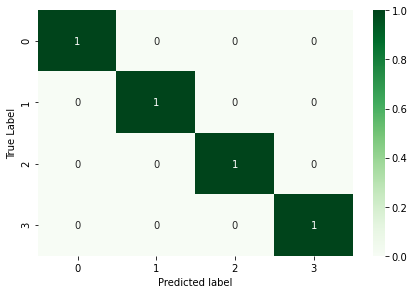

In [31]:
figure1 = plt.figure()
val_conf_matrix = val_conf_matrix.astype('float') / val_conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(val_conf_matrix, annot = True, cmap=plt.cm.Greens)
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted label')
plt.savefig('Validation data Confusion Matrix', dpi=250)
plt.show()

# **Test the model**

In [32]:
testing_datagen = ImageDataGenerator(rescale = 1./255)
test_data_datagen = testing_datagen.flow_from_directory(testing_dir, class_mode='categorical', target_size=(224,224), batch_size=1,shuffle=False)

Found 2128 images belonging to 4 classes.


In [33]:
print('Testing the model')
final_result = model.evaluate(
    test_data_datagen,
    steps = 2128)

Testing the model
2128/2128 [==============================] - 31s 14ms/step - loss: 0.0032 - accuracy: 0.9995


In [34]:
test_data_datagen.reset()
predict_on_test_data = model.predict(
    test_data_datagen,
    steps = 2128,
    verbose = 1
)

2128/2128 [==============================] - 30s 14ms/step


In [35]:
print('Number of data points in test set:',predict_on_test_data.shape[0])

Number of data points in test set: 2128


# **Produce a classification report for Test set**

In [0]:
predicted_classes = np.argmax(predict_on_test_data,axis=1)
predict_true_classes = test_data_datagen.classes
predict_class_labels = list(test_data_datagen.class_indices.keys())

Performance metrics for Test set

In [37]:
test_report = metrics.classification_report(predict_true_classes, predicted_classes, target_names = predict_class_labels)
print(test_report)

               precision    recall  f1-score   support

chicken_curry       1.00      1.00      1.00       552
    hamburger       1.00      1.00      1.00       534
     omelette       1.00      1.00      1.00       518
      waffles       1.00      1.00      1.00       524

     accuracy                           1.00      2128
    macro avg       1.00      1.00      1.00      2128
 weighted avg       1.00      1.00      1.00      2128



Confusion matrix with the numbers of true and predicted labels for each class in Test set

In [38]:
test_confusion_matrix = tf.math.confusion_matrix(labels=predict_true_classes,predictions = predicted_classes).numpy()
print(test_confusion_matrix)

[[552   0   0   0]
 [  1 533   0   0]
 [  0   0 518   0]
 [  0   0   0 524]]


Visualization of Confusion Matrix for Test set

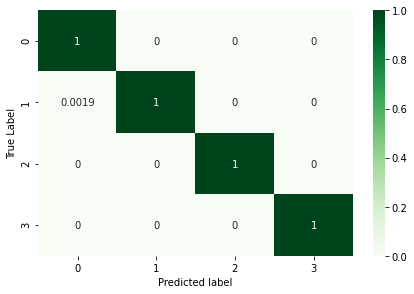

In [41]:
figure1 = plt.figure()
test_confusion_matrix = test_confusion_matrix.astype('float') / test_confusion_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(test_confusion_matrix, annot = True, cmap=plt.cm.Greens)
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted label')
plt.savefig('Test data Confusion Matrix', dpi=250)
plt.show()

# **Save the final CNN model**

In [42]:
model_json = model.to_json()
with open("model.json","w") as json_file:
  json_file.write(model_json)
  #serializing the weights to HDF5
model.save('RESNET-Final-Model.h5')
print('Model saved to the disk')

Model saved to the disk


# **Load the final CNN model**

In [43]:
json_file = open('model.json','r')
loaded_json_model = json_file.read()
json_file.close()
loaded_model=model_from_json(loaded_json_model)
loaded_model.load_weights("RESNET-Final-Model.h5")
print("Loaded the model from disk")

Loaded the model from disk


# **Author: Japesh Methuku**